## SENSE reconstruction 
###### Author: Zimu Huo
###### Date: 02.2022


-------------------------------------------------------------------------
References
    
    [1] 
    Author: Klaas P. Pruessmann et al. 
    Title: SENSE: Sensitivity Encoding for Fast MRI
    Link: https://pubmed.ncbi.nlm.nih.gov/10542355/

In [1]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import util.coil as coil 
import util.phantom as phantom
import numpy as np
import util.mask as undersample
from util.fft import *
# from util.SENSE import *
import util.io as io
from util.sense import * 
import util.simulator as simulator

In [2]:
indSlice = np.asarray([2], dtype = int)
numSlice = len(indSlice)
R = 2
from util.twix import *
file_sms = "../lib/meas_MID00134_FID55501_catesain_4slices.dat"
file = readtwix(file_sms)
data = file[0]['readouts'][...,::R,1]

Software version: VD/VE (!?)

Scan  0
100 % parsed in 1 s. Estimated 0 s remaining.
Scan  1
100 % parsed in 2 s. Estimated 0 s remaining.
----------------------------------------------------------------------------------------------------
reading raw data, calculating trajectories and sampling raster 


  0%|          | 0/1063 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
file parsed
----------------------------------------------------------------------------------------------------
loading and preprocessing the data..
----------------------------------------------------------------------------------------------------
dynamically combining data according to dtype, sli, par, rep..


  0%|          | 0/4 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
finished, the output is stored in a list format and each element of the list is a dictionary.
To access the data, use file[idx]["readout"] or file[idx]["flags"]
                                                                                                    
idx  file type
0   DATA


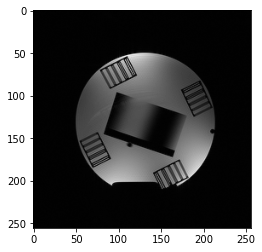

In [6]:
show(coil.rsos(ifft2c(data)))

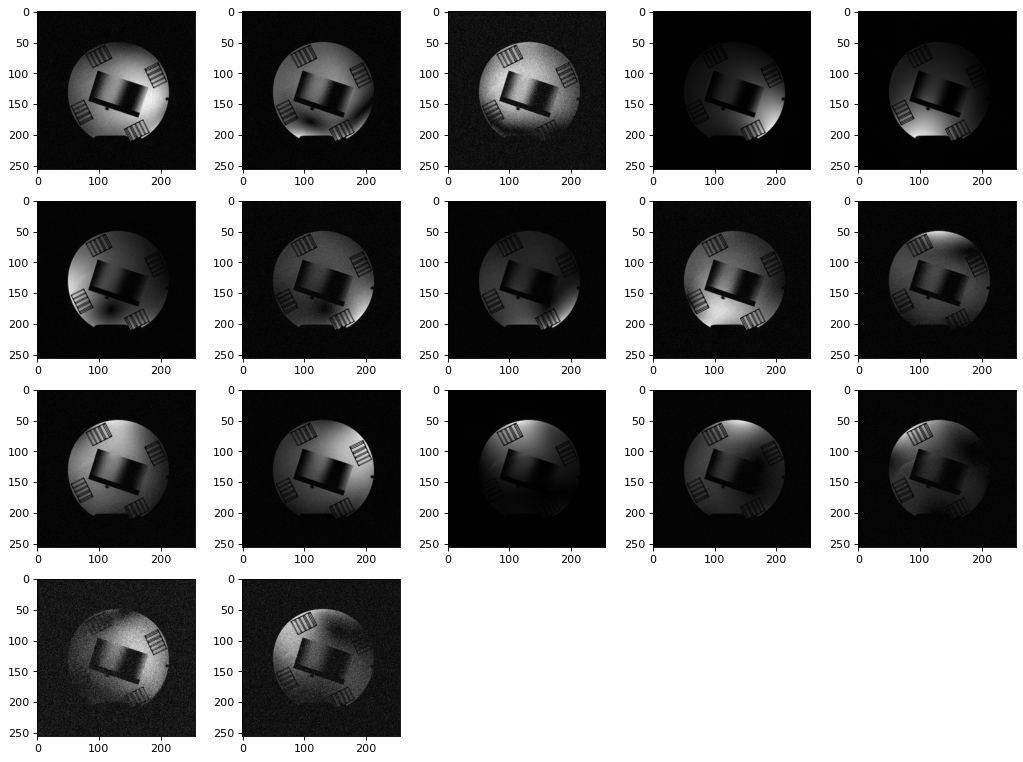

In [4]:
show(ifft2c(data))

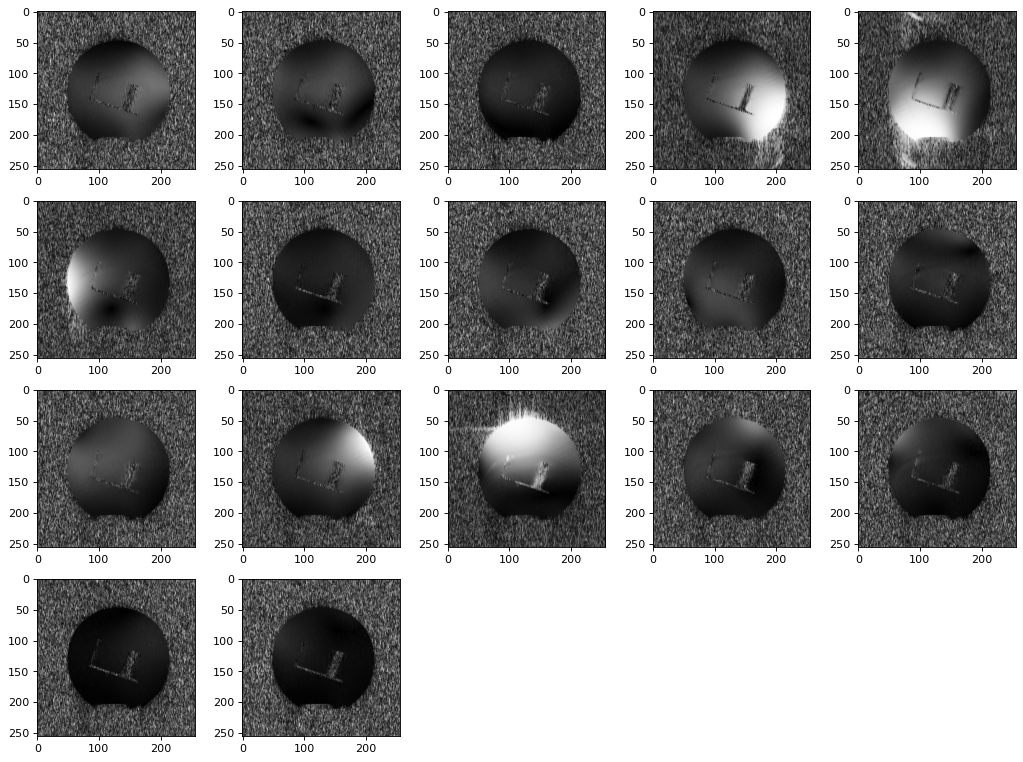

In [3]:
show(coil.inati_cmap(ifft2c(data)))

In [8]:
R = 2
dataR = data * undersample.sense(data.shape, R)
acs =  simulator.acs(data, (32,32))

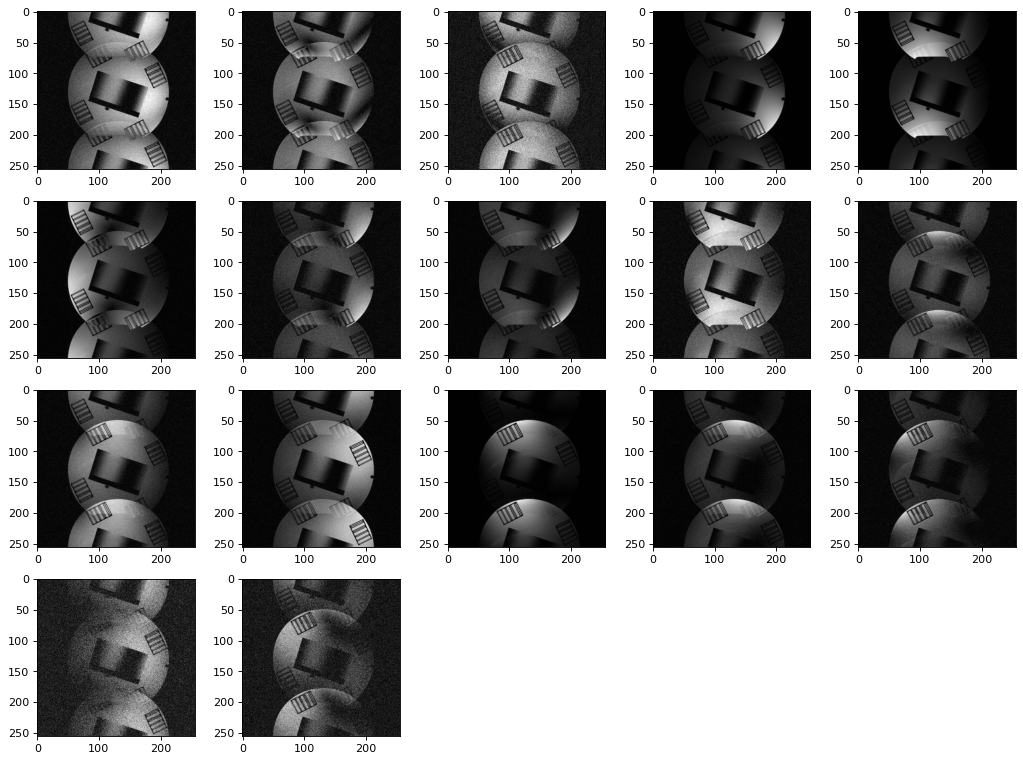

In [9]:
show(ifft2c(dataR))

In [6]:
from tqdm.notebook import tqdm
import util.coil as coil 
from util.zpad import * 
from util.fft import * 
def sense(dataR, acs, lamda = 1E-4):
    mask = np.where(dataR[:,0,0] == 0, 0, 1).flatten()
    R = int(np.ceil(mask.shape[0]/np.sum(mask)))
    [ny, nx, nc] = dataR.shape
    images = ifft2c(dataR)
    readny = int(ny/R)
    pat = ifft2c(zpad(acs, (ny, nx), (0,1)))
    coilmaps = coil.walsh_cmap(pat) 
    coilmaps = coilmaps / np.max(coil.rsos(coilmaps))
    recon = np.zeros([ny,nx], dtype = complex)
    for x in (range(nx)):
        for y in range(readny):
            yidx = np.arange(y,ny,readny)
            S = coilmaps[yidx,x,:]
            STS = S.T @ S     
            #M = np.linalg.inv(STS+np.eye(STS.shape[0])*lamda*np.linalg.norm(STS)/STS.shape[0])@S.T 
            M = np.linalg.pinv(STS)@S.T 
            recon[yidx,x] = M.T@images[y,x,:]
    return recon

In [7]:
recon = sense(dataR, acs)

In [ ]:
from util.zpad import * 
reconifft2c(zpad(fft2c(recon), (512, 256), (0,1)))

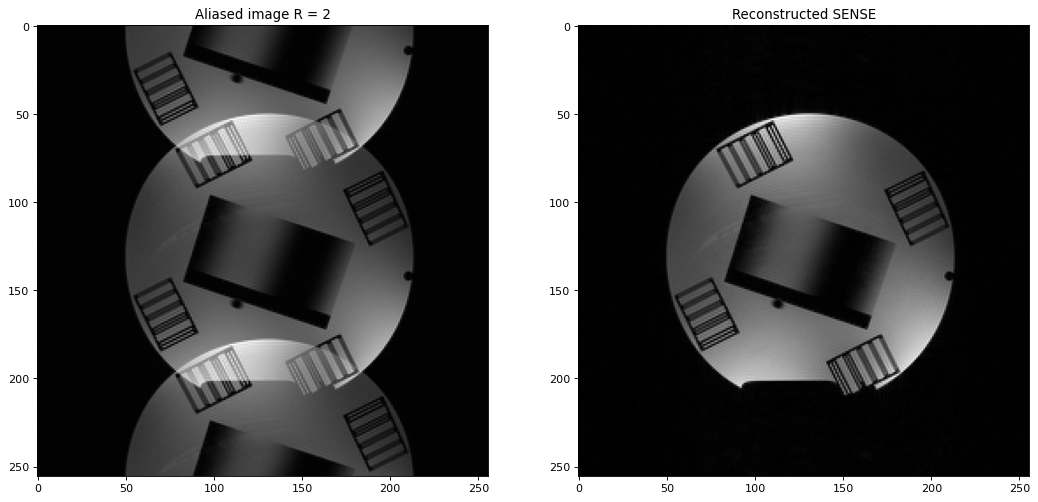

In [8]:
plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(121)
plt.imshow(np.abs(coil.rsos(ifft2c(dataR))), cmap='gray')
plt.title("Aliased image R = "+str(R))
plt.subplot(122)
plt.imshow(np.abs(recon), cmap='gray')
plt.title("Reconstructed SENSE")
plt.show()